# Finite Basis Kolmogorov-Arnold Networks (FBKANs) in Neuromancer

This tutorial demonstrates the use of Finite Basis Kolmogorov-Arnold Networks (FBKANs) for learning noisy data via domain decomposition.

### References

[1] [Liu, Ziming, et al. (2024). KAN: Kolmogorov-Arnold Networks.](https://arxiv.org/abs/2404.19756)

[2] https://github.com/Blealtan/efficient-kan

[3] Howard, Amanda A., et al. (2024) Finite basis Kolmogorov-Arnold networks: domain decomposition for data-diven and physics-informed problems.


### Install Neuromancer
(Note: You can skip this step if running locally.)
(Note 2: Colab might ask you to restart your session after installing Neuromancer. Simply restart it when prompted.)

In [1]:
import os

# Check if the neuromancer directory already exists
if not os.path.isdir('neuromancer'):
    # Clone the specific branch of the repository
    !git clone --branch feature/fbkans https://github.com/pnnl/neuromancer.git

# Navigate to the repository directory
%cd neuromancer

# Install the repository with the required extras
!pip install -e .[docs,tests,examples]


### Import dependencies

In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from neuromancer.dataset import DictDataset
from neuromancer.modules import blocks
from neuromancer.system import Node, System
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.callbacks import Callback
from neuromancer.loggers import LossLogger

from torch.utils.data import DataLoader


### Configure device and RNG seed

In [3]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)
#PyTorch random number generator
torch.manual_seed(1234)
# Random number generators in other libraries
np.random.seed(1234)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Generate data

We will use the function below to generate data from the function:

$$
f(x) = \exp\left[\sin\left(4 \pi x^2\right)\right],
$$

where $x \in [0,2]$. To simulate noise in the training data, random Gaussian noise with a standard deviation of 0.1 is added to the training labels.

In [4]:
def create_dataset(f,
                   n_var=2,
                   ranges = [0,1],
                   train_num=1000, 
                   test_num=1000,
                   normalize_input=False,
                   normalize_label=False,
                   device='cpu',
                   seed=0):
    '''
    create dataset
    
    Args:
    -----
        f : function
            the symbolic formula used to create the synthetic dataset
        ranges : list or np.array; shape (2,) or (n_var, 2)
            the range of input v|ariables. Default: [-1,1].
        train_num : int
            the number of training samples. Default: 1000.
        test_num : int
            the number of test samples. Default: 1000.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.
        
    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']
         
    Example
    -------
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2, train_num=100)
    >>> dataset['train_input'].shape
    torch.Size([100, 2])
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var,2)
    else:
        ranges = np.array(ranges)
        
    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:,i] = torch.rand(train_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]
        test_input[:,i] = torch.rand(test_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]
        
    train_label = f(train_input)
    test_label = f(test_input)
        
    def normalize(data, mean, std):
            return (data-mean)/std
            
    if normalize_input == True:
        mean_input = torch.mean(train_input, dim=0, keepdim=True)
        std_input = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input, std_input)
        test_input = normalize(test_input, mean_input, std_input)
        
    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label, std_label)
        test_label = normalize(test_label, mean_label, std_label)

    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)

    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)

    return dataset


In [5]:
# Function to sample from
f = lambda x: torch.exp((torch.sin(4*torch.pi*(x[:,[0]]**2))))

# Create dataset
dataset = create_dataset(f, n_var=1, ranges=[0,2], train_num=400, test_num=1000, device=device)

# Extract data directly as PyTorch tensors
X_train = dataset['train_input']
X_test = dataset['test_input']
y_train = dataset['train_label']
y_test = dataset['test_label']
y_clean = y_train.clone()

# Add noise to y_train
y_train += 0.1 * torch.randn_like(y_train)


In [6]:
# Wrap data into Neuromancer DictDatasets
train_data = DictDataset({'x': dataset['train_input'].to(device), 'y':dataset['train_label'].to(device)}, name='train')
dev_data = DictDataset({'x': dataset['test_input'].to(device), 'y':dataset['test_label'].to(device)}, name='dev')

# Create torch dataloaders with DictDatasets
batch_size = train_data.datadict['x'].shape[0]
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                         collate_fn=dev_data.collate_fn,
                                         shuffle=False)

### Create KAN blocks in Neuromancer

In [7]:
# Neural nets to solve the PDE problem
net_fbkan = blocks.KANBlock(insize=1,
                            outsize=1,
                            hsizes=[5], # hidden width
                            num_domains=10, # number of domains for domain decomposition
                            grid_sizes=[5], # grid size for KAN
                            spline_order=3, # spline order
                            grid_range=[0,2]
                            ).to(device)


net_kan = blocks.KANBlock(insize=1,
                          outsize=1,
                          hsizes=[5], # hidden width
                          num_domains=1,  # number of domains
                          grid_sizes=[5], # grid size for KAN
                          spline_order=3, # spline order
                          grid_range=[0,2]
                          ).to(device)

# Symbolic wrapper of the neural nets
neural_net_wrapper_fbkan = Node(net_fbkan, ['x'], ['y_hat'], name='net_wrapper_fbkan')
neural_net_wrapper_kan = Node(net_kan, ['x'], ['y_hat'], name='net_wrapper_kan')


### Define symbolic variables and losses

In [8]:
# Define symbolic variables in Neuromancer
# Note: y = f(x)
x = variable('x')
y = variable('y')
y_hat = variable('y_hat')

loss_data_fbkan = (y == y_hat)^2
loss_data_fbkan.name = "ref_loss_fbkan"

loss_data_kan = (y == y_hat)^2
loss_data_kan.name = "ref_loss_kan"

loss_fbkan = PenaltyLoss(objectives=[loss_data_fbkan], constraints=[])
loss_kan = PenaltyLoss(objectives=[loss_data_kan], constraints=[])


### Construct the Neuromancer Problem objects and train

In [9]:
# Construct the optimization problems
problem_fbkan = Problem(nodes=[neural_net_wrapper_fbkan],          # list of nodes (neural nets) to be optimized
                  loss=loss_fbkan,                                 # data loss
                  grad_inference=True                              # argument for allowing computation of gradients at the inference time
                 )

problem_kan = Problem(nodes=[neural_net_wrapper_kan],              # list of nodes (neural nets) to be optimized
                  loss=loss_kan,                                   # data loss
                  grad_inference=True                              # argument for allowing computation of gradients at the inference time
                 )

In [10]:
# Parameters for training
num_epochs = 2000
epoch_verbose = 50

# Initial learning rate
init_lr = 1e-2

# Create loggers
logger_fbkan = LossLogger(args=None, savedir='test_fbkan', verbosity=epoch_verbose, stdout=['train_loss','dev_loss'])
logger_kan = LossLogger(args=None, savedir='test_kan', verbosity=epoch_verbose, stdout=['train_loss', 'dev_loss'])

# Create trainers
trainer_fbkan = Trainer(
    problem_fbkan.to(device),
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer= torch.optim.Adam(problem_fbkan.parameters(), lr=init_lr),
    epoch_verbose=epoch_verbose,
    logger=logger_fbkan,
    epochs=num_epochs,
    train_metric='train_loss',
    eval_metric='dev_loss',
    dev_metric='dev_loss',
    warmup=num_epochs,
    device=device
)

trainer_kan = Trainer(
    problem_kan.to(device),
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer= torch.optim.Adam(problem_kan.parameters(), lr=init_lr),
    epoch_verbose=epoch_verbose,
    logger=logger_kan,
    epochs=num_epochs,
    train_metric='train_loss',
    eval_metric='dev_loss',
    dev_metric='dev_loss',
    warmup=num_epochs,
    device=device
)



None
None
Number of parameters: 1000
Number of parameters: 100


In [11]:
# Train KAN
best_model_kan = trainer_kan.train()
problem_kan.load_state_dict(best_model_kan)
trained_model_kan = problem_kan.nodes[0]
y_test_pred_kan = trained_model_kan(dev_data.datadict)['y_hat'].detach().numpy()


epoch: 0	train_loss: 2.72812	dev_loss: 2.43958	eltime:  0.02046
epoch: 50	train_loss: 0.69293	dev_loss: 0.67429	eltime:  0.24514
epoch: 100	train_loss: 0.63379	dev_loss: 0.61552	eltime:  0.53532
epoch: 150	train_loss: 0.54580	dev_loss: 0.51654	eltime:  0.76241
epoch: 200	train_loss: 0.47687	dev_loss: 0.47113	eltime:  0.98777
epoch: 250	train_loss: 0.43037	dev_loss: 0.42795	eltime:  1.21555
epoch: 300	train_loss: 0.34899	dev_loss: 0.35744	eltime:  1.43893
epoch: 350	train_loss: 0.25711	dev_loss: 0.23473	eltime:  1.66297
epoch: 400	train_loss: 0.14943	dev_loss: 0.14593	eltime:  1.88497
epoch: 450	train_loss: 0.11962	dev_loss: 0.12997	eltime:  2.10704
epoch: 500	train_loss: 0.09099	dev_loss: 0.10112	eltime:  2.33213
epoch: 550	train_loss: 0.07656	dev_loss: 0.08518	eltime:  2.55562
epoch: 600	train_loss: 0.06634	dev_loss: 0.07098	eltime:  2.84582
epoch: 650	train_loss: 0.05640	dev_loss: 0.05497	eltime:  3.06985
epoch: 700	train_loss: 0.04697	dev_loss: 0.04119	eltime:  3.29154
epoch: 750	tr

In [12]:
# Train FBKAN
best_model_fbkan = trainer_fbkan.train()
problem_fbkan.load_state_dict(best_model_fbkan)
trained_model_fbkan = problem_fbkan.nodes[0]
y_test_pred_fbkan = trained_model_fbkan(dev_data.datadict)['y_hat'].detach().numpy()


epoch: 0	train_loss: 2.78375	dev_loss: 2.51061	eltime:  9.18018
epoch: 50	train_loss: 0.59925	dev_loss: 0.55923	eltime:  10.47656
epoch: 100	train_loss: 0.31653	dev_loss: 0.32432	eltime:  11.87794
epoch: 150	train_loss: 0.18461	dev_loss: 0.19397	eltime:  13.19073
epoch: 200	train_loss: 0.05953	dev_loss: 0.05293	eltime:  14.49709
epoch: 250	train_loss: 0.01788	dev_loss: 0.01243	eltime:  15.88898
epoch: 300	train_loss: 0.01205	dev_loss: 0.00834	eltime:  17.16436
epoch: 350	train_loss: 0.01116	dev_loss: 0.00787	eltime:  18.40125
epoch: 400	train_loss: 0.01051	dev_loss: 0.00744	eltime:  19.67145
epoch: 450	train_loss: 0.00985	dev_loss: 0.00709	eltime:  21.00983
epoch: 500	train_loss: 0.00912	dev_loss: 0.00696	eltime:  22.25860
epoch: 550	train_loss: 0.00859	dev_loss: 0.00680	eltime:  23.50936
epoch: 600	train_loss: 0.00827	dev_loss: 0.00671	eltime:  24.82787
epoch: 650	train_loss: 0.00812	dev_loss: 0.00670	eltime:  26.06984
epoch: 700	train_loss: 0.00807	dev_loss: 0.00709	eltime:  27.31172

### Plot results

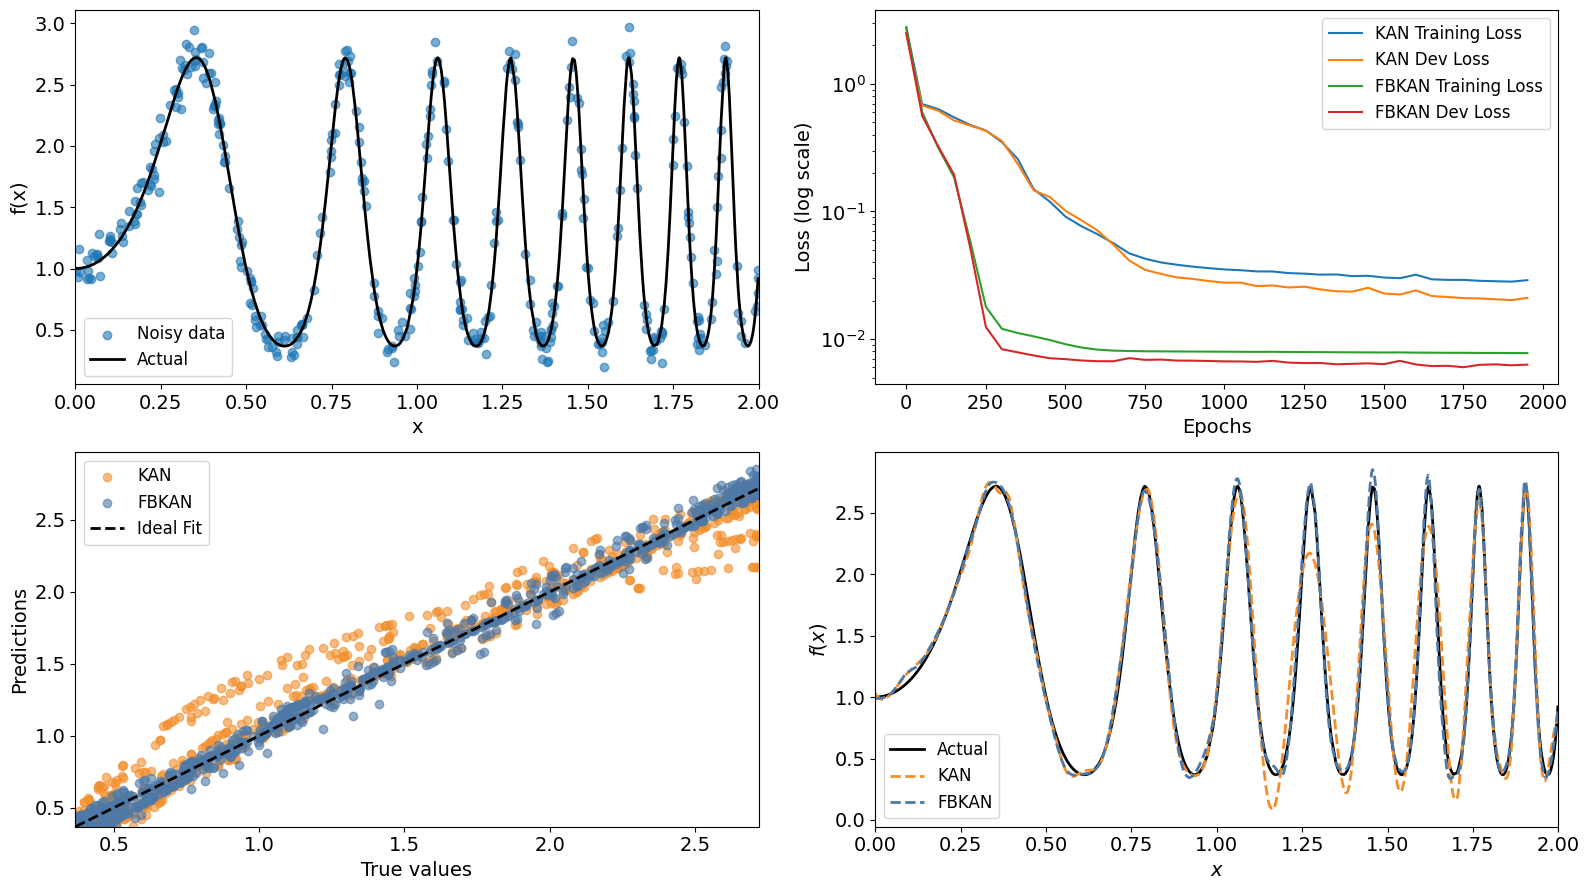

In [13]:
# Plotting
fig, ax = plt.subplots(2, 2, figsize=(16, 9))
losses_fbkan = trainer_fbkan.logger.get_losses()
losses_kan = trainer_kan.logger.get_losses()
sorted_indices = np.argsort(X_test[:, 0].numpy(), axis=0)
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]
y_test_pred_fbkan_sorted = y_test_pred_fbkan[sorted_indices]
y_test_pred_kan_sorted = y_test_pred_kan[sorted_indices]

# Plotting losses vs epochs with log scale on y-axis
epochs = range(1, len(losses_fbkan['train'])*epoch_verbose+1, epoch_verbose)

# Sorting the training data for plotting noisy data and clean function
inds = np.argsort(X_train[:, 0].numpy(), axis=0)
X_train_sorted = X_train[inds]
y_train_sorted = y_train[inds]

# Plotting noisy data and clean function
ax[0, 0].scatter(X_train_sorted[:, 0], y_train_sorted[:, 0], label='Noisy data', alpha=0.6)
ax[0, 0].plot(X_test_sorted[:, 0], y_test_sorted[:, 0], 'k', label='Actual', linewidth=2)
ax[0, 0].set_xlim([0, 2])
ax[0, 0].set_xlabel('x', fontsize=14)
ax[0, 0].set_ylabel(r'f(x)', fontsize=14)
ax[0, 0].legend(fontsize=12, ncol=1)
ax[0, 0].tick_params(labelsize=14)

# Plotting loss vs epochs
ax[0, 1].plot(epochs, losses_kan['train'], label='KAN Training Loss')
ax[0, 1].plot(epochs, losses_kan['dev'], label='KAN Dev Loss')
ax[0, 1].plot(epochs, losses_fbkan['train'], label='FBKAN Training Loss')
ax[0, 1].plot(epochs, losses_fbkan['dev'], label='FBKAN Dev Loss')
ax[0, 1].set_xlabel('Epochs', fontsize=14)
ax[0, 1].set_ylabel('Loss (log scale)', fontsize=14)
ax[0, 1].set_yscale('log')
ax[0, 1].legend(fontsize=12, ncol=1)
ax[0, 1].tick_params(labelsize=14)

# Plotting predictions vs true values
ax[1, 0].scatter(y_test_sorted, y_test_pred_kan_sorted, label='KAN', alpha=0.6, color='#f28e2b')
ax[1, 0].scatter(y_test_sorted, y_test_pred_fbkan_sorted, label='FBKAN', alpha=0.6, color='#4e79a7')
ax[1, 0].plot([y_test_sorted.min(), y_test_sorted.max()], [y_test_sorted.min(), y_test_sorted.max()], 'k--', lw=2, label='Ideal Fit')
ax[1, 0].set_xlim([y_test_sorted.min(), y_test_sorted.max()])
ax[1, 0].set_ylim([y_test_sorted.min(), y_test_sorted.max() + 0.25])
ax[1, 0].set_xlabel('True values', fontsize=14)
ax[1, 0].set_ylabel('Predictions', fontsize=14)
ax[1, 0].legend(fontsize=12, ncol=1)
ax[1, 0].tick_params(labelsize=14)

# Plotting function approximation
ax[1, 1].plot(X_test_sorted[:, 0], y_test_sorted[:, 0], 'k-', label='Actual', linewidth=2)
ax[1, 1].plot(X_test_sorted[:, 0], y_test_pred_kan_sorted[:, 0], '--', color='#f28e2b', label='KAN', linewidth=2)
ax[1, 1].plot(X_test_sorted[:, 0], y_test_pred_fbkan_sorted[:, 0], '--', color='#4e79a7', label='FBKAN', linewidth=2)
ax[1, 1].set_xlim([0, 2])
ax[1, 1].legend(fontsize=12, ncol=1)
ax[1, 1].tick_params(labelsize=14)
ax[1, 1].set_xlabel('$x$', fontsize=14)
ax[1, 1].set_ylabel('$f(x)$', fontsize=14)

plt.tight_layout()
plt.show()